# Librerías necesarias para trabajar

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 34.2 MB/s eta 0:00:00


In [ ]:
# Librerías básicas
import pandas as pd
import numpy as np
import json
import os
import pickle
from functools import partial

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import scipy.optimize as sp

# Optimización de hiperparámetros
import optuna

# Utilidades
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import joblib
import warnings

# Google Colab
from google.colab import drive

# Configuración
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_columns', None)

# Carga de datos

In [ ]:
from google.colab import drive

# 1. Montar Google Drive
drive.mount('/content/drive')

# 2. Definir rutas
ruta_zip_en_drive = "/content/drive/MyDrive/data_pet_adoption.zip"
ruta_destino_local = "/content/dataset_local"

# 3. Copiar y Descomprimir (Solo si no lo has hecho ya)
if not os.path.exists(ruta_destino_local):
    print("Copiando y descomprimiendo datos... (esto puede tardar un poco)")

    # Creamos la carpeta local
    os.makedirs(ruta_destino_local, exist_ok=True)

    # Comando de sistema para descomprimir rápido
    # -q es para que no imprima miles de líneas (quiet)
    # -d es el destino
    !unzip -q "{ruta_zip_en_drive}" -d "{ruta_destino_local}"

    print("¡Datos listos en el entorno local!")
else:
    print("Los datos ya estaban descomprimidos.")

Mounted at /content/drive
Copiando y descomprimiendo datos... (esto puede tardar un poco)
¡Datos listos en el entorno local!


# EDA

## train.csv

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/train.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 14993 filas x 24 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2



--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


## color_labels.csv

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/color_labels.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 7 filas x 2 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream



--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ColorID    7 non-null      int64 
 1   ColorName  7 non-null      object
dtypes: int64(1), object(1)
memory usage: 244.0+ bytes

--- 3. DESCRIBE (Estadísticas) ---


,ColorID
count,7.000000
mean,4.000000
std,2.160247
min,1.000000
25%,2.500000
50%,4.000000
75%,5.500000
max,7.000000


## state_labels.csv

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/state_labels.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 15 filas x 2 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan



--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   StateID    15 non-null     int64 
 1   StateName  15 non-null     object
dtypes: int64(1), object(1)
memory usage: 372.0+ bytes

--- 3. DESCRIBE (Estadísticas) ---


,StateID
count,15.000000
mean,41349.733333
std,29.001149
min,41324.000000
25%,41328.500000
50%,41336.000000
75%,41364.000000
max,41415.000000


## breed_labels

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/breed_labels.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 307 filas x 3 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita



--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   BreedID    307 non-null    int64 
 1   Type       307 non-null    int64 
 2   BreedName  307 non-null    object
dtypes: int64(2), object(1)
memory usage: 7.3+ KB

--- 3. DESCRIBE (Estadísticas) ---


,BreedID,Type
count,307.000000,307.000000
mean,154.000000,1.214984
std,88.767487,0.411482
min,1.000000,1.000000
25%,77.500000,1.000000
50%,154.000000,1.000000
75%,230.500000,1.000000
max,307.000000,2.000000


## train_sentiment.csv

In [ ]:
import pandas as pd
import json
import os
from tqdm.notebook import tqdm

# 1. Definir la ruta
sentiment_path = '/content/dataset_local/petfinder-adoption-prediction/train_sentiment'

# 2. Preparamos una lista para guardar los datos
sentiment_data = []

# 3. Obtenemos la lista de archivos (limitamos a .json)
files = [f for f in os.listdir(sentiment_path) if f.endswith('.json')]

print(f"📂 Encontrados {len(files)} archivos de sentimiento. Procesando...")

# 4. Bucle para leer cada archivo
for filename in tqdm(files):
    file_path = os.path.join(sentiment_path, filename)

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            json_content = json.load(f)

        # Extraemos lo que nos interesa
        # El PetID es el nombre del archivo sin el ".json"
        pet_id = filename.split('.')[0]

        # Datos del JSON
        score = json_content['documentSentiment']['score']
        magnitude = json_content['documentSentiment']['magnitude']
        language = json_content['language']

        # Guardamos en la lista
        sentiment_data.append({
            'PetID': pet_id,
            'SentimentScore': score,
            'SentimentMagnitude': magnitude,
            'Language': language
        })

    except Exception as e:
        print(f"Error leyendo {filename}: {e}")

# 5. Convertimos la lista a DataFrame
df_sentiment = pd.DataFrame(sentiment_data)

print("✅ Tabla de Sentimientos creada exitosamente.")

# --- A. VISTA PREVIA ---
print("\n--- 1. PRIMERAS FILAS ---")
display(df_sentiment.head())

# --- B. ESTADÍSTICAS DEL SENTIMIENTO ---
print("\n--- 2. ESTADÍSTICAS (Score y Magnitud) ---")
# Esto es crucial:
# - Si la media del Score es cercana a 1, todo el mundo habla bien de sus mascotas.
# - Si la Magnitud media es baja, las descripciones son muy cortas o secas.
display(df_sentiment[['SentimentScore', 'SentimentMagnitude']].describe())

# --- C. IDIOMAS ---
print("\n--- 3. IDIOMAS DETECTADOS ---")
# ¿Están todos en inglés ('en')? ¿Hay alguno en malayo ('ms')?
idiomas = df_sentiment['Language'].value_counts()
display(idiomas)

# --- D. TIPOS DE DATOS ---
print("\n--- 4. INFO TÉCNICA ---")
df_sentiment.info()

📂 Encontrados 14442 archivos de sentimiento. Procesando...


  0%|          | 0/14442 [00:00<?, ?it/s]

✅ Tabla de Sentimientos creada exitosamente.

--- 1. PRIMERAS FILAS ---


,PetID,SentimentScore,SentimentMagnitude,Language
0,40f1ee340,0.0,1.5,en
1,0adebbf21,0.0,1.7,en
2,bb4c6519d,0.0,0.0,en
3,532b5a798,0.3,1.2,en
4,4194f0f66,0.2,2.3,en



--- 2. ESTADÍSTICAS (Score y Magnitud) ---


,SentimentScore,SentimentMagnitude
count,14442.000000,14442.000000
mean,0.280951,2.127628
std,0.276766,2.036914
min,-0.900000,0.000000
25%,0.100000,0.800000
50%,0.300000,1.600000
75%,0.400000,2.800000
max,0.900000,32.000000



--- 3. IDIOMAS DETECTADOS ---


,count
Language,
en,14309
zh,95
zh-Hant,36
de,2



--- 4. INFO TÉCNICA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442 entries, 0 to 14441
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PetID               14442 non-null  object 
 1   SentimentScore      14442 non-null  float64
 2   SentimentMagnitude  14442 non-null  float64
 3   Language            14442 non-null  object 
dtypes: float64(2), object(2)
memory usage: 451.4+ KB


# Pipeline ETL: Preprocesamiento y Feature Engineering

In [ ]:
# Configuración visual
pd.set_option('display.max_columns', None)
tqdm.pandas()

# =============================================================================
# 1. CONFIGURACIÓN DE RUTAS
# =============================================================================
PATHS = {
    'train': '/content/dataset_local/petfinder-adoption-prediction/train.csv',
    'breeds': '/content/dataset_local/petfinder-adoption-prediction/breed_labels.csv',
    'colors': '/content/dataset_local/petfinder-adoption-prediction/color_labels.csv',
    'states': '/content/dataset_local/petfinder-adoption-prediction/state_labels.csv',
    'sentiment_dir': '/content/dataset_local/petfinder-adoption-prediction/train_sentiment'
}

# =============================================================================
# 2. CARGA DE DATOS Y CORRECCIÓN PREVENTIVA
# =============================================================================
print("🚀 Iniciando Pipeline Maestro...")

# Cargar CSVs
df_main = pd.read_csv(PATHS['train'])
df_breeds = pd.read_csv(PATHS['breeds'])
df_colors = pd.read_csv(PATHS['colors'])
df_states = pd.read_csv(PATHS['states'])

print(f"   - Dataset original: {df_main.shape}")

# --- FIX CRÍTICO: COLUMNA 'TYPE' ---
# El archivo de razas también tiene una columna 'Type'. Si no la quitamos antes de
# unir, Pandas creará conflictos y corromperá la columna Type original.
if 'Type' in df_breeds.columns:
    df_breeds = df_breeds.drop('Type', axis=1)

# =============================================================================
# 3. FUSIÓN DE DATOS (ENRICHMENT)
# =============================================================================

# A. Razas (Traemos los nombres para Master, mantenemos IDs para ML)
df_main = df_main.merge(df_breeds, left_on='Breed1', right_on='BreedID', how='left')
df_main.rename(columns={'BreedName': 'Breed1_Name'}, inplace=True)
df_main.drop('BreedID', axis=1, inplace=True)

df_main = df_main.merge(df_breeds, left_on='Breed2', right_on='BreedID', how='left')
df_main.rename(columns={'BreedName': 'Breed2_Name'}, inplace=True)
df_main.drop('BreedID', axis=1, inplace=True)

# B. Colores
for i in [1, 2, 3]:
    col_name = f'Color{i}'
    df_main = df_main.merge(df_colors, left_on=col_name, right_on='ColorID', how='left')
    df_main.rename(columns={'ColorName': f'{col_name}_Name'}, inplace=True)
    df_main.drop('ColorID', axis=1, inplace=True)

# C. Estados
df_main = df_main.merge(df_states, left_on='State', right_on='StateID', how='left')
df_main.rename(columns={'StateName': 'State_Name'}, inplace=True)
df_main.drop('StateID', axis=1, inplace=True)

print("✅ Tablas fusionadas correctamente (sin perder 'Type').")

# =============================================================================
# 4. EXTRACCIÓN DE SENTIMIENTOS (NLP)
# =============================================================================
print("⏳ Procesando Sentimientos (JSON)...")

def extract_sentiment(pet_id):
    path = os.path.join(PATHS['sentiment_dir'], f"{pet_id}.json")
    score, magnitude, language = 0, 0, 'en'

    if os.path.exists(path):
        try:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                score = data['documentSentiment']['score']
                magnitude = data['documentSentiment']['magnitude']
                language = data['language']
        except:
            pass
    return pd.Series([score, magnitude, language])

df_main[['SentimentScore', 'SentimentMagnitude', 'Language']] = df_main['PetID'].progress_apply(extract_sentiment)

# =============================================================================
# 5. FEATURE ENGINEERING (INGENIERÍA DE CARACTERÍSTICAS)
# =============================================================================
print("🛠️ Creando Variables Derivadas...")

# A. Variables de Texto
invalid_names = ['no name', 'noname', 'none', 'na', 'unknown', 'sin nombre', '0']
df_main['HasName'] = df_main['Name'].apply(
    lambda x: 0 if pd.isna(x) or str(x).lower().strip() in invalid_names or len(str(x)) < 2 else 1
)
df_main['DescWordCount'] = df_main['Description'].fillna("").apply(lambda x: len(str(x).split()))

# B. Variables Biológicas (Mestizaje y Edad)
df_main['IsMixedBreed'] = df_main.apply(
    lambda x: 1 if (x['Breed1'] == 307 or x['Breed2'] == 307 or (x['Breed2'] != 0 and x['Breed1'] != x['Breed2'])) else 0, axis=1
)
df_main['AgeBin'] = pd.cut(df_main['Age'], bins=[-1, 3, 12, 60, 255], labels=[0, 1, 2, 3]).astype(int)

# C. Variables Económicas y Multimedia
df_main['IsFree'] = (df_main['Fee'] == 0).astype(int)
df_main['TotalMultimedia'] = df_main['PhotoAmt'] + df_main['VideoAmt']

# D. Sentimiento Avanzado
df_main['SentimentImpact'] = df_main['SentimentScore'] * df_main['SentimentMagnitude']

# =============================================================================
# 6. LIMPIEZA FINAL Y CREACIÓN DE DATASETS
# =============================================================================

# --- A. Guardar MASTER (Humano) ---
# Rellenamos nulos visuales para el CSV maestro
df_master = df_main.copy()
text_cols = ['Breed1_Name', 'Breed2_Name', 'Color1_Name', 'Color2_Name', 'Color3_Name', 'State_Name']
for col in text_cols:
    if col in df_master.columns:
        df_master[col] = df_master[col].fillna("None")

df_master['Name'].fillna("No Name", inplace=True)
df_master['Description'].fillna("", inplace=True)

df_master.to_csv('master.csv', index=False)
print(f"📄 'master.csv' generado. (Contiene texto legible y {df_master.shape[0]} filas)")


# --- B. Guardar TRAIN READY (Máquina) ---
print("🧹 Preparando dataset numérico para LightGBM...")
df_model = df_master.copy()

# 1. Eliminamos columnas de TEXTO o IDs inútiles para el modelo
cols_to_drop = [
    'Name', 'Description', 'RescuerID', 'PetID',  # Texto libre / IDs únicos
    'Breed1_Name', 'Breed2_Name',                 # Redundantes (ya tenemos Breed1 ID)
    'Color1_Name', 'Color2_Name', 'Color3_Name',  # Redundantes (ya tenemos Color1 ID)
    'State_Name', 'Language'                      # Texto
]
# Solo borramos si existen
df_model.drop(columns=[c for c in cols_to_drop if c in df_model.columns], inplace=True)

# 2. Encoding manual de lo que falta
# State era texto en master, necesitamos recuperar el ID o codificarlo.
# Como borramos StateID al inicio, usamos el State_Name recuperado en Master, pero para el modelo
# lo transformamos a número.
if 'State_Name' in df_main.columns:
     # Usamos Label Encoding sobre el dataframe original antes de borrar
     df_model['State'] = df_main['State_Name'].astype('category').cat.codes

# 3. Asegurar tipos numéricos (Ints donde corresponda)
cols_int = ['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
            'Sterilized', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']
for col in cols_int:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype(int)

# Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('AdoptionSpeed', axis=1), df_model['AdoptionSpeed'], test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# Guardar
df_train.to_csv('train_ready.csv', index=False)
df_test.to_csv('test_ready.csv', index=False)

print("="*60)
print(f"🎉 ¡TODO LISTO! Archivo para entrenar: 'train_ready.csv'")
print(f"📊 Dimensiones para el modelo: {df_train.shape}")
print(f"⚠️ Nulos restantes en el modelo: {df_model.isnull().sum().sum()} (Debería ser 0)")
print("="*60)

# Muestra final del dataset numérico
display(df_model.head(3))

🚀 Iniciando Pipeline Maestro...
   - Dataset original: (14993, 24)
✅ Tablas fusionadas correctamente (sin perder 'Type').
⏳ Procesando Sentimientos (JSON)...


  0%|          | 0/14993 [00:00<?, ?it/s]

🛠️ Creando Variables Derivadas...
📄 'master.csv' generado. (Contiene texto legible y 14993 filas)
🧹 Preparando dataset numérico para LightGBM...
🎉 ¡TODO LISTO! Archivo para entrenar: 'train_ready.csv'
📊 Dimensiones para el modelo: (11994, 29)
⚠️ Nulos restantes en el modelo: 0 (Debería ser 0)


,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,SentimentScore,SentimentMagnitude,HasName,DescWordCount,IsMixedBreed,AgeBin,IsFree,TotalMultimedia,SentimentImpact
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,12,0,1,2,0.3,2.4,1,69,0,0,0,1.0,0.72
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,3,0,2,0,-0.2,0.7,1,23,0,0,1,2.0,-0.14
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,12,0,7,3,0.2,3.7,1,69,1,0,1,7.0,0.74


# Entrenamiento del modelo

El objetivo de este proyecto es predecir la velocidad de adopción (`AdoptionSpeed`), una variable que toma valores enteros del **0 al 4**. Al existir un orden intrínseco (donde 0 es "muy rápido" y 4 es "muy lento"), tratar este problema como una clasificación estándar no es lo ideal.

A continuación, planteamos un esquema experimental para superar un modelo base mediante técnicas específicas de **Clasificación Ordinal**.

---

**El Baseline**: Clasificación Multiclase Estándar
Como punto de partida, entrenaremos un modelo **LightGBM** con objetivo `multiclass`.
* **Enfoque:** Trata cada etiqueta (0, 1, 2, 3, 4) como categorías independientes, igual que si estuviéramos clasificando "Manzana", "Pera" o "Plátano".
* **El Problema:** Este enfoque ignora la distancia entre clases. Para el modelo, equivocarse prediciendo una clase 4 cuando la realidad es 0 es "igual de malo" que predecir una clase 1.
* **Consecuencia:** Al optimizar la tasa de aciertos (Accuracy) o LogLoss, no optimizamos necesariamente la métrica del concurso: **Quadratic Weighted Kappa (QWK)**, que penaliza mucho más los errores lejanos.

---

**Estrategia A: Enfoque Métrico (Regresión + Cortes Optimizados)**
Aprovechando que las etiquetas tienen un orden numérico, trataremos el problema como una **Regresión**.
* **Lógica:** Asumimos que la velocidad de adopción es una variable continua latente.
* **Entrenamiento:** Usamos LightGBM con `objective='regression'` minimizando el **RMSE** (Error Cuadrático Medio). Matemáticamente, minimizar RMSE es un excelente *proxy* para maximizar QWK.
* **Post-Procesamiento (Nelder-Mead):** La regresión devuelve números decimales (ej: 2.34). En lugar de redondear al entero más cercano (0.5, 1.5...), utilizaremos el algoritmo **Nelder-Mead** para encontrar los umbrales de corte que maximicen el QWK en el conjunto de validación.

---

**Estrategia B: Enfoque Probabilístico (Frank & Hall / Ordinal Decomposition)**
Este método transforma el problema de $K$ clases en $K-1$ problemas de clasificación binaria jerárquica.
* **Lógica:** En lugar de preguntar "¿Es clase 2?", preguntamos secuencialmente: "¿Es mayor que la clase 0?", "¿Es mayor que la clase 1?", etc.
* **Implementación:**
    1. Entrenamos un clasificador para $P(y > 0)$.
    2. Entrenamos otro para $P(y > 1)$, y así sucesivamente.
    3. Reconstruimos la probabilidad de cada clase restando las probabilidades acumuladas: $P(y=k) = P(y > k-1) - P(y > k)$.
* **Ventaja:** Captura la naturaleza ordinal sin forzar una distancia numérica rígida como la regresión.

## Baseline

In [ ]:
# =============================================================================
# CARGA DE DATOS
# =============================================================================
print("📥 Cargando dataset preparado...")
df_train = pd.read_csv('train_ready.csv')

# Separamos X (Variables) e y (Objetivo)
X = df_train.drop(['AdoptionSpeed'], axis=1)
y = df_train['AdoptionSpeed']

# Convertimos a array numpy para evitar problemas de índices en KFold
X_values = X.values
y_values = y.values

print(f"✅ Datos listos: {X.shape[0]} filas, {X.shape[1]} columnas.")

# =============================================================================
# MOTOR DE OPTIMIZACIÓN (OPTUNA + CV)
# =============================================================================

def objective(trial):
    params = {
        # Parámetros fijos
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 1000,

        # Espacio de búsqueda
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 150),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.95),
    }

    # Usamos CV estratificado
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    qwk_scores = []

    for train_idx, val_idx in folds.split(X_values, y_values):
        X_train, y_train = X_values[train_idx], y_values[train_idx]
        X_val, y_val = X_values[val_idx], y_values[val_idx]

        model = lgb.LGBMClassifier(**params)

        # Callbacks para evitar overfitting (parada temprana)
        callbacks = [
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=callbacks
        )

        preds = model.predict(X_val)
        qwk = cohen_kappa_score(y_val, preds, weights='quadratic')
        qwk_scores.append(qwk)

    return np.mean(qwk_scores)

# =============================================================================
# EJECUCIÓN
# =============================================================================
print("🚀 Iniciando búsqueda de Hiperparámetros con Optuna...")

# Definimos un Sampler con semilla fija
sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(direction='maximize', sampler=sampler) # Queremos maximizar QWK
study.optimize(objective, n_trials=60)

print("\n🏆 MEJORES RESULTADOS ENCONTRADOS:")
print(f"   Best QWK Score: {study.best_value:.5f}")
print("   Best Params:", study.best_params)

# =============================================================================
# ENTRENAMIENTO DEL MODELO FINAL (BASELINE)
# =============================================================================
print("\n⚙️ Entrenando modelo final con todo el dataset (X, y)...")

# 1. Recuperamos los parámetros fijos (los mismos que definiste dentro de 'objective')
fixed_params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 1000
}

# 2. Fusionamos con los mejores hiperparámetros encontrados por Optuna
final_params = {**fixed_params, **study.best_params}

# 3. Instanciamos el modelo final
best_model_baseline = lgb.LGBMClassifier(**final_params)

# 4. Entrenamos con TODO el conjunto de datos (sin dividir en train/val)
best_model_baseline.fit(X, y)

print("✅ Modelo Baseline entrenado y listo para inferencia.")

# Guardar el modelo
joblib.dump(best_model_baseline, 'modelo_baseline_optuna.pkl')

📥 Cargando dataset preparado...
✅ Datos listos: 11994 filas, 28 columnas.
🚀 Iniciando búsqueda de Hiperparámetros con Optuna...

🏆 MEJORES RESULTADOS ENCONTRADOS:
   Best QWK Score: 0.35595
   Best Params: {'learning_rate': 0.026706465976760102, 'num_leaves': 227, 'max_depth': 8, 'min_data_in_leaf': 10, 'lambda_l1': 5.625301598881684, 'lambda_l2': 2.742609439724943, 'bagging_fraction': 0.8509806319480983, 'bagging_freq': 7, 'feature_fraction': 0.8385153792500151}

⚙️ Entrenando modelo final con todo el dataset (X, y)...
✅ Modelo Baseline entrenado y listo para inferencia.


['modelo_baseline_optuna.pkl']

## Estrategia A: Regresión + Cortes Optimizados

In [ ]:
# =============================================================================
# CARGA DE DATOS
# =============================================================================
print("📥 Cargando dataset preparado...")
df_train = pd.read_csv('train_ready.csv')

# Separamos X (Variables) e y (Objetivo)
X = df_train.drop(['AdoptionSpeed'], axis=1)
y = df_train['AdoptionSpeed']

# Convertimos a array numpy para evitar problemas de índices en KFold
X_values = X.values
y_values = y.values

print(f"✅ Datos listos: {X.shape[0]} filas, {X.shape[1]} columnas.")

# =============================================================================
# HERRAMIENTA DE CORTE (OPTIMIZED ROUNDER)
# =============================================================================
# Esta clase busca los mejores puntos de corte para convertir regresión a clases
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        # Rompe la predicción continua en clases usando los cortes (coef)
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        # Calculamos QWK. Negativo porque scipy busca minimizar, y nosotros queremos maximizar kappa
        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        # Cortes iniciales estándar (0.5, 1.5, 2.5, 3.5)
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Scipy minimiza la función de pérdida buscando los mejores coeficientes
        self.coef_ = sp.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p.astype(int)

# =============================================================================
# ESTRATEGIA 1: SPLIT DE CALIBRACIÓN
# =============================================================================
def objective_fast(trial):
    params = {
        # Parámetros fijos
        'objective': 'rmse',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 1000,

        # Espacio de búsqueda
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 150),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.95),
    }

    # Validación Cruzada (K-Fold)
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    kappa_scores = []

    for train_idx, val_idx in folds.split(X_values, y_values):
        # Datos del fold
        X_train_full, y_train_full = X_values[train_idx], y_values[train_idx]
        X_val, y_val = X_values[val_idx], y_values[val_idx]

        # Dividimos el Train en "Train Real" y "Calibración"
        X_train_inner, X_calib, y_train_inner, y_calib = train_test_split(
            X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
        )

        # Instanciamos el modelo
        model = lgb.LGBMRegressor(**params)

        # Early Stopping
        callbacks = [
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]


        # Entrenar
        model.fit(
            X_train_inner, y_train_inner,
            eval_set=[(X_calib, y_calib)],
            eval_metric='rmse',
            callbacks=callbacks
        )

        # Optimizamos Cortes usando X_calib (predicciones honestas)
        calib_preds = model.predict(X_calib)
        optR = OptimizedRounder()
        optR.fit(calib_preds, y_calib)

        # Evaluamos en Validación Final con los cortes aprendidos
        val_preds = model.predict(X_val)
        val_class = optR.predict(val_preds, optR.coef_['x'])

        kappa_scores.append(cohen_kappa_score(y_val, val_class, weights='quadratic'))

    return np.mean(kappa_scores)



# =============================================================================
# ESTRATEGIA 2: VALIDACIÓN CRUZADA ANIDADA
# =============================================================================
def objective_robust(trial):
    params = {
        # Parámetros fijos
        'objective': 'rmse',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 1000,

        # Espacio de búsqueda
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 150),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.95),
    }

    # Bucle EXTERNO (5 Folds)
    outer_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    kappa_scores = []

    for train_idx, val_idx in outer_folds.split(X_values, y_values):
        X_train, y_train = X_values[train_idx], y_values[train_idx]
        X_val, y_val = X_values[val_idx], y_values[val_idx]

        # Bucle INTERNO (3 Folds) sobre X_train para sacar cortes robustos
        inner_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        inner_oof_preds = np.zeros(len(X_train))

        # Generamos predicciones OOF sobre todo el Train set
        for in_tr_idx, in_val_idx in inner_folds.split(X_train, y_train):
            X_in_tr, y_in_tr = X_train[in_tr_idx], y_train[in_tr_idx]
            X_in_val, y_in_val = X_train[in_val_idx], y_train[in_val_idx]

            model_inner = lgb.LGBMRegressor(**params)
            # Usamos el split interno validación para Early Stopping
            cbs = [lgb.early_stopping(stopping_rounds=30, verbose=False)]
            model_inner.fit(X_in_tr, y_in_tr, eval_set=[(X_in_val, y_in_val)],
                            eval_metric='rmse', callbacks=cbs)

            inner_oof_preds[in_val_idx] = model_inner.predict(X_in_val)

        # Ajustamos cortes usando TODAS las predicciones OOF de train
        optR = OptimizedRounder()
        optR.fit(inner_oof_preds, y_train)
        robust_cuts = optR.coef_['x']

        # Entrenamos modelo FINAL del fold (Usando X_train completo)
        model_final = lgb.LGBMRegressor(**params)
        cbs_final = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        model_final.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                        eval_metric='rmse', callbacks=cbs_final)

        # Predecimos y aplicamos cortes robustos
        val_preds_raw = model_final.predict(X_val)
        val_preds_class = optR.predict(val_preds_raw, robust_cuts)

        kappa_scores.append(cohen_kappa_score(y_val, val_preds_class, weights='quadratic'))

    return np.mean(kappa_scores)



# =============================================================================
# EJECUCIÓN
# =============================================================================
# --- CONFIGURACIÓN ---
# Cambia esto a:
#   1 -> Para usar Split de Calibración (Rápido, recomendado por defecto)
#   2 -> Para usar Nested CV Interno (Más lento, máxima robustez académica)
ESTRATEGIA = 2
N_TRIALS = 60
# ---------------------

print(f"🚀 Iniciando Optuna con ESTRATEGIA {ESTRATEGIA}...")
print(f"   Modo: {'Split de Calibración (Fast)' if ESTRATEGIA == 1 else 'Nested CV para Cortes (Robust)'}")

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

if ESTRATEGIA == 1:
    study.optimize(objective_fast, n_trials=N_TRIALS)
else:
    study.optimize(objective_robust, n_trials=N_TRIALS)

print("\n🏆 MEJORES RESULTADOS:")
print(f"   Best QWK Score: {study.best_value:.5f}")
print("   Best Params:", study.best_params)


# =============================================================================
# ENTRENAMIENTO DEL MODELO GANADOR
# =============================================================================
class PetFinderModel:
    """
    Clase que encapsula el ensemble de 5 modelos y los cortes óptimos.
    Se guarda como un único objeto .pkl
    """
    def __init__(self, models, avg_cuts):
        self.models = models      # Lista con los 5 modelos LGBM
        self.avg_cuts = avg_cuts  # Array con los cortes promedio [c1, c2, c3, c4]

    def predict(self, X):
        # Obtenemos predicciones crudas de los 5 modelos. Matriz de forma (n_samples, 5)
        raw_preds = np.column_stack([model.predict(X) for model in self.models])

        # Promediamos las predicciones (Bagging)
        avg_pred = np.mean(raw_preds, axis=1)

        # Aplicamos los cortes guardados (Discretización)
        final_preds = np.zeros(len(avg_pred), dtype=int)

        # Lógica vectorizada de cortes (más rápido que un bucle for)
        c = self.avg_cuts
        final_preds[(avg_pred >= c[0]) & (avg_pred < c[1])] = 1
        final_preds[(avg_pred >= c[1]) & (avg_pred < c[2])] = 2
        final_preds[(avg_pred >= c[2]) & (avg_pred < c[3])] = 3
        final_preds[avg_pred >= c[3]] = 4

        return final_preds

# =============================================================================
# ENTRENAMIENTO DEL ENSEMBLE
# =============================================================================
print("⚙️ Entrenando Ensemble Final (Se guardará en un solo archivo)...")

# Recuperamos mejores params y añadimos fijos
fixed_params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 1000
}

best_params = {**fixed_params, **study.best_params}

temp_models = []
temp_cuts = []

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (train_idx, val_idx) in enumerate(folds.split(X_values, y_values)):
    print(f"  > Fold {fold_+1}/5")

    X_train, y_train = X_values[train_idx], y_values[train_idx]

    X_val, y_val = X_values[val_idx], y_values[val_idx]

    # Entrenar
    model = lgb.LGBMRegressor(**best_params)
    callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', callbacks=callbacks)

    # Optimizar cortes para este fold
    optR = OptimizedRounder()
    optR.fit(model.predict(X_val), y_val)

    # Guardar en listas temporales
    temp_models.append(model)
    temp_cuts.append(optR.coef_['x'])

# =============================================================================
# EMPAQUETADO Y GUARDADO FINAL
# =============================================================================
# Calculamos el promedio de los cortes de los 5 folds
avg_cuts_final = np.mean(temp_cuts, axis=0)

# Creamos la instancia de nuestra clase personalizada
final_model_object = PetFinderModel(models=temp_models, avg_cuts=avg_cuts_final)

# Guardamos TODO en un solo archivo
joblib.dump(final_model_object, 'modelo_final_completo.pkl')

print("\n✅ ¡Hecho! Todo el sistema está guardado en 'modelo_final_completo.pkl'")
print(f"✂️ Cortes promedio integrados: {avg_cuts_final}")

📥 Cargando dataset preparado...
✅ Datos listos: 11994 filas, 28 columnas.
🚀 Iniciando Optuna con ESTRATEGIA 2...
   Modo: Nested CV para Cortes (Robust)

🏆 MEJORES RESULTADOS:
   Best QWK Score: 0.39827
   Best Params: {'learning_rate': 0.012616378696286807, 'num_leaves': 234, 'max_depth': 10, 'min_data_in_leaf': 79, 'lambda_l1': 3.3991483777508917, 'lambda_l2': 0.4768325348206979, 'bagging_fraction': 0.832136915207364, 'bagging_freq': 5, 'feature_fraction': 0.6205167081709819}
⚙️ Entrenando Ensemble Final (Se guardará en un solo archivo)...
  > Fold 1/5
  > Fold 2/5
  > Fold 3/5
  > Fold 4/5
  > Fold 5/5

✅ ¡Hecho! Todo el sistema está guardado en 'modelo_final_completo.pkl'
✂️ Cortes promedio integrados: [0.48923221 1.86477354 2.51543645 2.86839824]


## Estrategia B: Estrategia Frank & Hall

In [ ]:
# =============================================================================
# CARGA DE DATOS
# =============================================================================
print("📥 Cargando dataset preparado...")
df_train = pd.read_csv('train_ready.csv')

# Separamos X (Variables) e y (Objetivo)
X = df_train.drop(['AdoptionSpeed'], axis=1)
y = df_train['AdoptionSpeed']

# Convertimos a array numpy para evitar problemas de índices en KFold
X_values = X.values
y_values = y.values

print(f"✅ Datos listos: {X.shape[0]} filas, {X.shape[1]} columnas.")

# =============================================================================
# DEFINICIÓN DE LA CLASE FRANK & HALL (Wrapper)
# =============================================================================
class OrdinalLGBM(BaseEstimator, ClassifierMixin):
    def __init__(self, **lgbm_params):
        self.lgbm_params = lgbm_params
        self.models = {}
        self.classes_ = None

    def fit(self, X, y, **kwargs):
        self.classes_ = np.sort(np.unique(y))

        # Entrenamos K-1 clasificadores binarios
        for i in range(len(self.classes_) - 1):
            cutoff = self.classes_[i]

            # El target es 1 si la etiqueta real es > cutoff, 0 si no
            binary_target = (y > cutoff).astype(int)

            # Configuramos el modelo interno como BINARIO
            current_params = self.lgbm_params.copy()

            # --- CORRECCIÓN CRÍTICA AQUÍ ---
            # Eliminamos 'num_class' porque choca con 'binary'
            current_params.pop('num_class', None)
            # -------------------------------

            current_params['objective'] = 'binary'
            current_params['metric'] = 'binary_logloss'
            current_params['verbose'] = -1

            # Adaptamos los argumentos extra (eval_set, etc.)
            fit_params = kwargs.copy()

            # Si hay eval_set, hay que binarizar también sus etiquetas
            if 'eval_set' in fit_params:
                new_eval_set = []
                for (X_val, y_val) in fit_params['eval_set']:
                    # Binarizamos la validación igual que el train
                    y_val_bin = (y_val > cutoff).astype(int)
                    new_eval_set.append((X_val, y_val_bin))

                fit_params['eval_set'] = new_eval_set

            clf = lgb.LGBMClassifier(**current_params)

            # Pasamos fit_params (que ya tiene el eval_set arreglado)
            clf.fit(X, binary_target, **fit_params)

            self.models[cutoff] = clf

        return self

    def predict_proba(self, X):
        # Matriz para guardar P(y > k)
        # Dimensiones: [n_muestras, n_clases - 1]
        probas_gt = np.zeros((X.shape[0], len(self.classes_) - 1))

        # Obtenemos P(y > k) de cada modelo
        for i, cutoff in enumerate(self.classes_[:-1]):
            # predict_proba devuelve [P(0), P(1)]. Queremos P(1)
            probas_gt[:, i] = self.models[cutoff].predict_proba(X)[:, 1]

        # Reconstruimos la probabilidad de cada clase específica
        # P(y = k) = P(y > k-1) - P(y > k)
        final_probas = np.zeros((X.shape[0], len(self.classes_)))

        # P(y > -1) es siempre 1.0 por definición
        prev_prob = np.ones(X.shape[0])

        for i in range(len(self.classes_) - 1):
            current_gt_prob = probas_gt[:, i]
            # Probabilidad de la clase actual es la diferencia
            final_probas[:, i] = prev_prob - current_gt_prob

            # Aseguramos que no haya probabilidades negativas por errores de redondeo
            final_probas[:, i] = np.clip(final_probas[:, i], 0, 1)

            prev_prob = current_gt_prob

        final_probas[:, -1] = prev_prob # El resto va a la última clase

        return final_probas

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# =============================================================================
# MOTOR DE OPTIMIZACIÓN (OPTUNA + CV)
# =============================================================================

def objective(trial):
    params = {
        # Parámetros fijos
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 1000,

        # Espacio de búsqueda
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 150),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.95),
    }

    # Usamos CV estratificado
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    qwk_scores = []

    for train_idx, val_idx in folds.split(X_values, y_values):
        X_train, y_train = X_values[train_idx], y_values[train_idx]
        X_val, y_val = X_values[val_idx], y_values[val_idx]

        model = OrdinalLGBM(**params)

        # Callbacks para evitar overfitting (parada temprana)
        callbacks = [
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=callbacks
        )

        preds = model.predict(X_val)
        qwk = cohen_kappa_score(y_val, preds, weights='quadratic')
        qwk_scores.append(qwk)

    return np.mean(qwk_scores)

# =============================================================================
# EJECUCIÓN
# =============================================================================
print("🚀 Iniciando búsqueda de Hiperparámetros con Optuna...")

# Definimos un Sampler con semilla fija
sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(direction='maximize', sampler=sampler) # Queremos maximizar QWK
study.optimize(objective, n_trials=60)

print("\n🏆 MEJORES RESULTADOS ENCONTRADOS:")
print(f"   Best QWK Score: {study.best_value:.5f}")
print("   Best Params:", study.best_params)


# =============================================================================
# ENTRENAMIENTO DEL MODELO FINAL (Frank & Hall)
# =============================================================================
print("\n⚙️ Entrenando modelo final con todo el dataset (X, y)...")

# 1. Recuperamos los parámetros fijos (los mismos que definiste dentro de 'objective')
fixed_params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 1000
}

# 2. Fusionamos con los mejores hiperparámetros encontrados por Optuna
final_params = {**fixed_params, **study.best_params}

# 3. Instanciamos el modelo final
best_model_frank_hall = OrdinalLGBM(**final_params)

# 4. Entrenamos con TODO el conjunto de datos (sin dividir en train/val)
best_model_frank_hall.fit(X, y)

print("✅ Modelo Frank & Hall entrenado y listo para inferencia.")

# Guardar el modelo
joblib.dump(best_model_frank_hall, 'modelo_fran_hall_optuna.pkl')

📥 Cargando dataset preparado...
✅ Datos listos: 11994 filas, 28 columnas.
🚀 Iniciando búsqueda de Hiperparámetros con Optuna...

🏆 MEJORES RESULTADOS ENCONTRADOS:
   Best QWK Score: 0.36535
   Best Params: {'learning_rate': 0.018463543178562022, 'num_leaves': 65, 'max_depth': 11, 'min_data_in_leaf': 22, 'lambda_l1': 3.6048091869468073, 'lambda_l2': 4.387210944978563, 'bagging_fraction': 0.8841543590754222, 'bagging_freq': 5, 'feature_fraction': 0.7783675284193583}

⚙️ Entrenando modelo final con todo el dataset (X, y)...
✅ Modelo Frank & Hall entrenado y listo para inferencia.


['modelo_fran_hall_optuna.pkl']

# Inferencia sobre el conjunto test no visto hasta ahora

In [ ]:
# Cargar test
df_test = pd.read_csv('test_ready.csv')
X_test = df_test.drop(['AdoptionSpeed'], axis=1)
y_test = df_test['AdoptionSpeed']

# Evaluar cada modelo
for nombre, modelo_path in [
    ('Baseline', 'modelo_baseline_optuna.pkl'),
    ('Regresión', 'modelo_final_completo.pkl'),
    ('Frank & Hall', 'modelo_fran_hall_optuna.pkl')
]:
    modelo = joblib.load(modelo_path)
    preds = modelo.predict(X_test)
    qwk = cohen_kappa_score(y_test, preds, weights='quadratic')
    print(f"{nombre}: QWK = {qwk:.4f}")

Baseline: QWK = 0.3809
Regresión: QWK = 0.4291
Frank & Hall: QWK = 0.4125


# Feature Importance

✅ Nombres recuperados: ['Type', 'Age', 'Breed1', 'Breed2', 'Gender']... (28 en total)


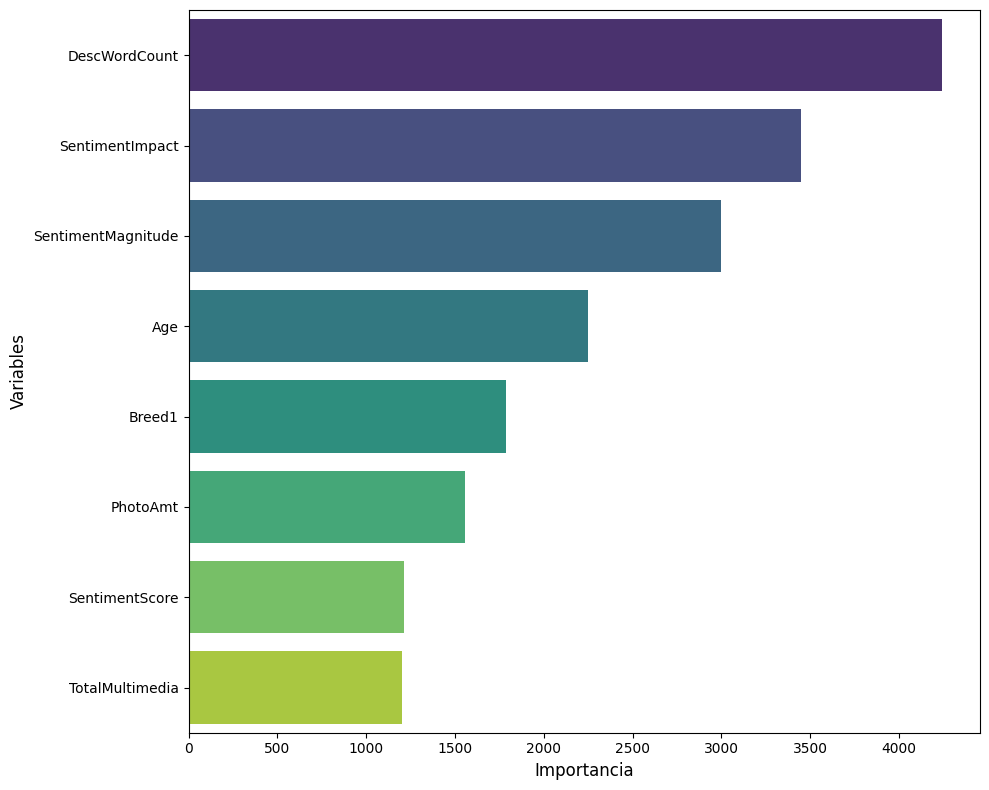

In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. DEFINICIÓN DE CLASE (Necesaria para cargar el pkl)
# ==========================================
class PetFinderModel:
    def __init__(self, models, avg_cuts):
        self.models = models
        self.avg_cuts = avg_cuts

# ==========================================
# 2. RECUPERAR NOMBRES DE COLUMNAS
# ==========================================
df_headers = pd.read_csv('train_ready.csv', nrows=1)
feature_names = df_headers.drop(['AdoptionSpeed'], axis=1).columns.tolist()

print(f"✅ Nombres recuperados: {feature_names[:5]}... ({len(feature_names)} en total)")

# ==========================================
# 3. CARGAR MODELO Y EXTRAER IMPORTANCIA
# ==========================================
sistema_completo = joblib.load('modelo_final_completo.pkl')

feature_importances = pd.DataFrame()

for i, model in enumerate(sistema_completo.models):
    fold_importance = pd.DataFrame()

    fold_importance["feature"] = feature_names
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = i + 1

    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

# ==========================================
# 4. GRAFICAR (Top 20 Variables)
# ==========================================
cols = (feature_importances[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:8].index)

best_features = feature_importances.loc[feature_importances.feature.isin(cols)]

plt.figure(figsize=(10, 8))
sns.barplot(
    x="importance",
    y="feature",
    data=best_features.sort_values(by="importance", ascending=False),
    palette="viridis",
    errorbar=None
)

plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.tight_layout()
plt.show()